In [10]:
import os
os.chdir('C:/Users/Kamar/Videos/ML_datasets/Spermatozoa/')

In [11]:
#Importing the required library
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout, Activation, InputLayer, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam



from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input


from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf

import cv2

import numpy as np

In [12]:
#Loading the Dataset
labels = ['agg', 'non_agg']
img_size =224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [13]:

#Now we can easily fetch our train and split it into traing and validation data.
train = get_data( '../Spermatozoa/')
train, val = train_test_split(train, test_size=0.20, random_state=42)

C:\Users\Kamar\AppData\Local\Temp/ipykernel_3576/4161325820.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


C:\Users\Kamar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

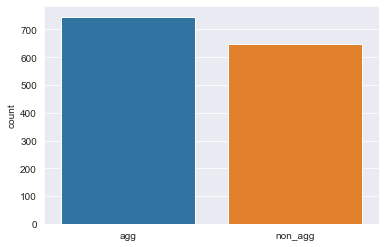

In [14]:
#Data Visualization
l = []
for i in train:
    if(i[1] == 0):
        l.append('agg')
    else:
        l.append('non_agg')
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'agg')

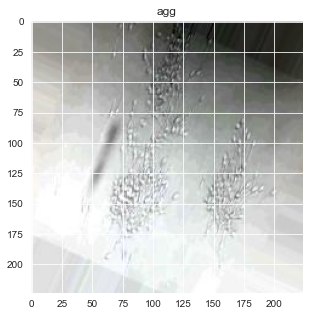

In [15]:

#Random image from agglutination
plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'non_agg')

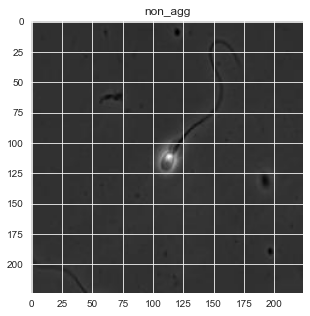

In [16]:

#Random image from non aggluntination 
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [17]:
#Data Preprocessing
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [18]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

In [19]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [21]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dropout(0.5))
model.add(Dense(2,activation='sigmoid'))

In [22]:
for layer in base_model.layers:
  layer.trainable = False

In [23]:
# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [24]:
opt = Adam(lr=0.000001)
model.compile(optimizer = opt ,loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

C:\Users\Kamar\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
history = model.fit(x_train,y_train,epochs = 20, validation_data = (x_val, y_val))

Epoch 1/20


C:\Users\Kamar\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


44/44 [==============================] - 812s 19s/step - loss: 1.2284 - accuracy: 0.5527 - val_loss: 0.6382 - val_accuracy: 0.5788
Epoch 2/20
44/44 [==============================] - 700s 16s/step - loss: 1.0052 - accuracy: 0.6014 - val_loss: 0.5578 - val_accuracy: 0.8281
Epoch 3/20
44/44 [==============================] - 645s 15s/step - loss: 0.9660 - accuracy: 0.6495 - val_loss: 0.4723 - val_accuracy: 0.8968
Epoch 4/20
44/44 [==============================] - 777s 18s/step - loss: 0.8327 - accuracy: 0.6839 - val_loss: 0.3970 - val_accuracy: 0.8997
Epoch 5/20
44/44 [==============================] - 750s 17s/step - loss: 0.7318 - accuracy: 0.7197 - val_loss: 0.3385 - val_accuracy: 0.8968
Epoch 6/20
44/44 [==============================] - 619s 14s/step - loss: 0.6813 - accuracy: 0.7520 - val_loss: 0.2944 - val_accuracy: 0.8997
Epoch 7/20
44/44 [==============================] - 590s 13s/step - loss: 0.6726 - accuracy: 0.7584 - val_loss: 0.2632 - val_accuracy: 0.8997
Epoch 8/20
44/44 

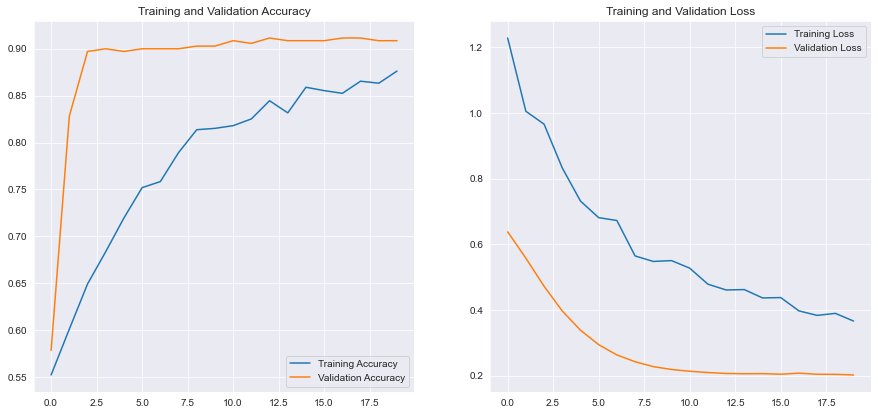

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
classification= model.predict(x_val)
classification = np.argmax(classification,axis=1)

print(classification_report(y_val, classification, target_names = ['agg (Class 0)','non_agg (Class 1)']))

                   precision    recall  f1-score   support

    agg (Class 0)       0.93      0.90      0.91       191
non_agg (Class 1)       0.88      0.92      0.90       158

         accuracy                           0.91       349
        macro avg       0.91      0.91      0.91       349
     weighted avg       0.91      0.91      0.91       349

